(All code source are cited in the code cell)
# 1. 
(a) 試簡述何謂維度的詛咒？試列舉一案例說明。

* 維度詛咒的定義，即為當模型所需要估計的未知參數不斷上升，所需要的樣本數量會呈現指數型的成長。

* 維度詛咒的後果：將會導致演算法不易收斂、收斂時出現多重解、過度配適、出現稀疏性等問題。

* 維度詛咒的舉例：台大學生為了終結聖誕魔咒，舉辦一個配對遊戲，若是表單上只有自己的性別以及期望的性別，且參與者性別、性向皆大致平均分配，適配度（即與自己理想型的落差） 100% 的機率將會很高，但隨著表單增加越來越多個維度，包含年齡、興趣、身高、體重...，台大學生配對到的適配度就會越來越低，聖誕魔咒會越來越難打破。

(b) 避免維度詛咒的方法有哪些？

避免維度詛咒主要可以透過維度縮減，而其中有許多維度縮減的方法：
* 重要變數挑選：可以先進行重要變數挑選，將對於結果沒有顯著影響的變數拿掉，縮減維度
* PCA 主成分分析：將維度軸旋轉，使得投影到較低維度的投影點方差最大化，以保留最多數據之間的特性

(c) 試找一個開放數據(e.g. Kaggle 開放數據)並選一種方法(e.g. 線性迴歸或決策樹)，用模擬方法固定樣本數但逐步增加變數個數，試著重新繪製圖 3.12，呈現維度與預測(或分類)績效間的關係。(提示：模擬方法可思考如下：(1)先做線性迴歸(2)重要變數依 p-value排序(3)將重要的變數一個個依序放入迴歸並計算 adjusted-R2 作為預測準確度)

* 本數據集來源：https://archive.ics.uci.edu/dataset/464/superconductivty+data
* 作法：尋找擁有大量維度的數據集，並且使用線性迴歸，並將重要變數依 p-value排序，再將重要的變數一個個依序放入迴歸並計算 adjusted-R2 作為預測準確度。

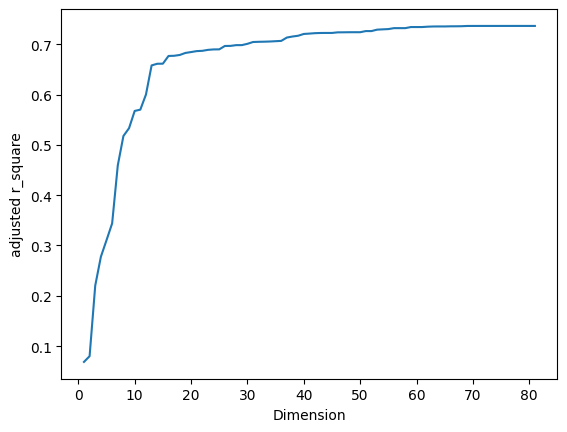

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
data = pd.read_csv("train.csv")
columns = list(data.columns)
columns.pop()
x = data[columns]
y = data['critical_temp']
regr = linear_model.LinearRegression()
regr.fit(x, y)
x = sm.add_constant(x) # adding a constant
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
p_value_index = model.pvalues.index
sorted_pvalue = model.pvalues
sorted_pvalue, p_value_index = zip(*sorted(zip(sorted_pvalue, p_value_index)))

para = []
dimensions = []
adj_rsquared = []
for i in p_value_index:
    if i == 'const': continue
    para.append(i)
    j = data[para]
    regr = linear_model.LinearRegression()
    regr.fit(j, y)
    j = sm.add_constant(j)
    model = sm.OLS(y, j).fit()
    dimensions.append(len(para))
    adj_rsquared.append(model.rsquared_adj)
    # print('dimensions: {:>2}  adjusted r_square: {:>15}'.format(len(para),model.rsquared_adj))
plt.plot(dimensions, adj_rsquared)
plt.xlabel('Dimension')
plt.ylabel('adjusted r_square')
plt.show()

(d)若準確度有或沒有明顯下降，請試著說明為什麼？

在這份資料當中，有82個維度以及21263個row，沒有缺失值，而根據 Widrow's Ruls of Thumb，I >= 10W，本資料集有足夠的 I 使得預測績效不致明顯下降，但預測準確度確實在維度數量超過 13 以後上升的非常緩慢。

# 2.

(a)試說明損失函數與模型評估指標有何不同？

模型訓練時使用損失函數，模型訓練後使用評估指標。
* 損失函數：通常需要滿足一些特性，例如具備「微分特性」、「連續性」等性質。通常只能比較相對性，無法解釋絕對的誤差大小
* 評估指標：用以衡量訓練後的模型表現，評估最終結果，需具備「公平性」與「比較性」

(b)試使用網際網路(internet)學習，損失函數的設計有哪些？試列舉兩種，並說明其各自的優缺點或可建議的使用時機。

* Precision (for Information Retreival)：其公式為 `true_positive / (true_positive + false positive)`。根據資訊檢索的特性，recall 通常不是資訊檢索在乎的點，因為 Relevant 的文件是固定的，因此是 recall 為一個 non-decreasing function。比起 recall 更在乎 precision，期望在越前面的排名得到越高的 precision。
* MSE 與 MAE：MAE 對 outlier 比較有用，但因為微分不連續(在 x=0 時， MAE 函數就不可以微分)，因此可能在執行時容易出錯，MSE 對 outlier 較敏感，但在求解時，比較容易找到穩定的解。若是樣本數夠大，outlier 的影響將微乎其微，可以使用 MSE。(source: https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E5%9F%BA%E7%A4%8E%E4%BB%8B%E7%B4%B9-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-2dcac5ebb6cb)

(c)如何根據不同情況選擇損失函數？試舉例或用開放數據說明之。

以下兩點使用問題 1. 的數據集進行分析。
* 根據問題 (b) 的資料搜尋，本題先就 MAE 以及 MSE 在不同隨機樣本數的表現進行驗證，且為求圖表呈現易於比較，MSE 使用 RMSE 並減去常數項以使得其範圍接近 MAE。由下圖可見，兩個損失函數在不同樣本下震盪幅度皆差不多，惟樣本數少時 MAE 較 MSE 波動幅度小一點，且同樣在樣本數增加後趨於穩定，就此資料集而言兩個損失函數並沒有太多差異。
* 下圖亦對 MAPE 進行分析，其損失函數愈趨近 0 時表現愈好。由圖表中可見，此損失函數沒有比 MSE 以及 MAE 來的穩定（見下表），特別在樣本小的時候有很大的表現落差。一般認為 MAPE 在不同列之間的實質目標值有顯著差異的時候比較適合使用，例如受到月份的影響。

|                | MSE           |   MAE |   MAPE |
|:--------------:|:-------------:|:-----:|:------:|
| Variance        |   0.2281 |0.1345|35.5271|

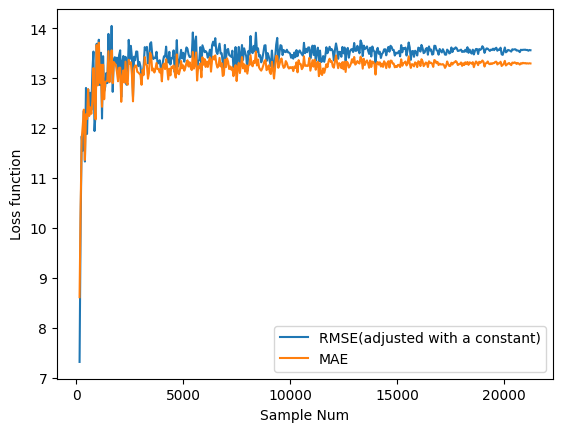

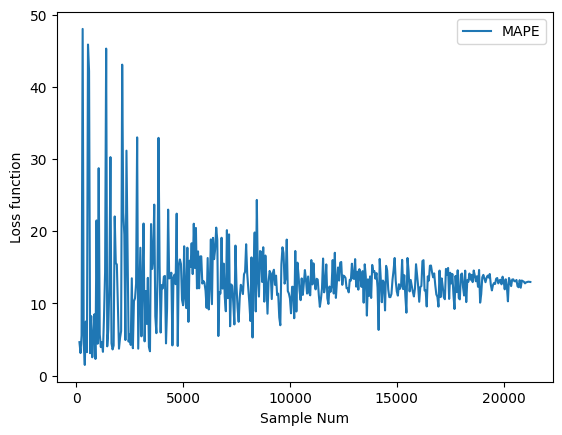

Var(MSE): 0.20075615081442494 
Var(MAE): 0.12121908436227477 
Var(MAPE) 30.667659142089143


In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

data_2 = data

# source: https://www.796t.com/article.php?id=14755

MSE = []
MAE = []
MAPE = []
row_num = 100
row_num_list = []
for i in range(int(len(data) / 50) - 2):
    row_num += 50
    sampled_x = data_2[columns].sample(row_num)
    sampled_y = data_2['critical_temp'][sampled_x.index]
    regr = linear_model.LinearRegression()
    regr.fit(sampled_x, sampled_y)
    predictions = regr.predict(sampled_x) 
    MAE.append(mean_absolute_error(predictions, sampled_y))
    MSE.append(mean_squared_error(predictions, sampled_y) ** (1/2) - 4)
    MAPE.append(mean_absolute_percentage_error(sampled_y, predictions))
    row_num_list.append(row_num)
    # print('dimensions: {:>2}  adjusted r_square: {:>15}'.format(len(para),model.rsquared_adj))
plt.plot(row_num_list, MSE, label = 'RMSE(adjusted with a constant)')
plt.plot(row_num_list, MAE, label = 'MAE')
# plt.plot(row_num_list, MAPE, label = 'MAPE')
plt.legend()
plt.xlabel('Sample Num')
plt.ylabel('Loss function')
plt.show()

plt.plot(row_num_list, MAPE, label = 'MAPE')
plt.legend()
plt.xlabel('Sample Num')
plt.ylabel('Loss function')
plt.show()
print('Var(MSE):', np.var(MSE), '\nVar(MAE):', np.var(MAE), '\nVar(MAPE)', np.var(MAPE))

為繼續探討 MAPE 的使用情境，在此導入另一個數據集(來源：https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)，評估每天共享腳踏車的使用數據，此數據集中理論上會受到每天的狀況不同導致實質目標值有顯著不同。

由下圖以及下表可見，MAPE 的誤差相較於 MAE 與 MSE 有顯著的減少，因此 MAPE 對於此類每個列目標值有合理變化的數據集，為一個比較適當的損失函數。

|                | MSE           |   MAE |   MAPE |
|:--------------:|:-------------:|:-----:|:------:|
| Variance        |  12109.4918 |6542.7647|0.09315|

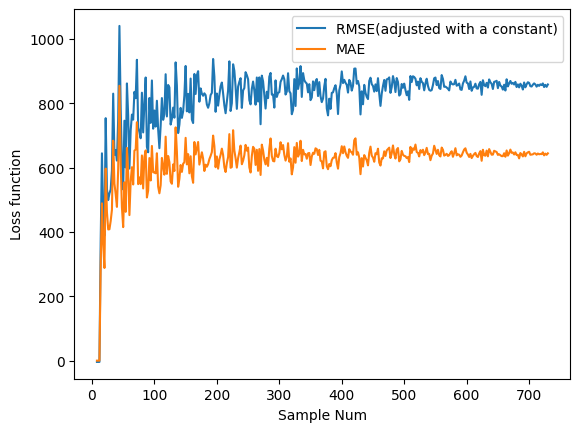

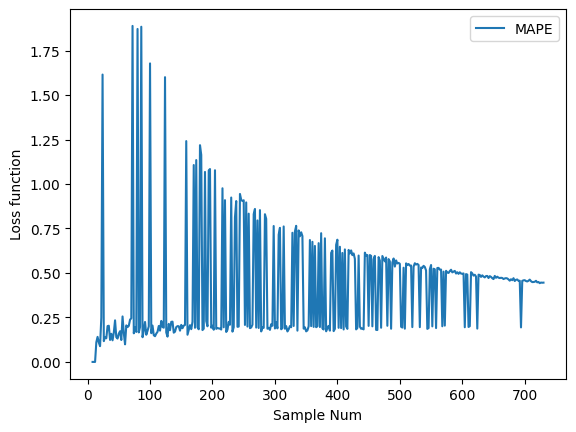

Var(MSE): 11682.72356766623 
Var(MAE): 6175.20072584434 
Var(MAPE) 0.08965873535433593


In [4]:
bike_data = pd.read_csv('day.csv')
bike_data_columns = ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
MSE = []
MAE = []
MAPE = []
row_num = 6
row_num_list = []
for i in range(int(len(bike_data)/2) - 3):
    row_num += 2
    sampled_x = bike_data[bike_data_columns].sample(row_num)
    sampled_y = bike_data['cnt'][sampled_x.index]
    regr = linear_model.LinearRegression()
    regr.fit(sampled_x, sampled_y)
    predictions = regr.predict(sampled_x) 
    MAE.append(mean_absolute_error(predictions, sampled_y))
    MSE.append(mean_squared_error(predictions, sampled_y) ** (1/2) - 4)
    MAPE.append(mean_absolute_percentage_error(sampled_y, predictions))
    row_num_list.append(row_num)
    # print('dimensions: {:>2}  adjusted r_square: {:>15}'.format(len(para),model.rsquared_adj))
plt.plot(row_num_list, MSE, label = 'RMSE(adjusted with a constant)')
plt.plot(row_num_list, MAE, label = 'MAE')
# plt.plot(row_num_list, MAPE, label = 'MAPE')
plt.legend()
plt.xlabel('Sample Num')
plt.ylabel('Loss function')
plt.show()

plt.plot(row_num_list, MAPE, label = 'MAPE')
plt.legend()
plt.xlabel('Sample Num')
plt.ylabel('Loss function')
plt.show()
print('Var(MSE):', np.var(MSE), '\nVar(MAE):', np.var(MAE), '\nVar(MAPE)', np.var(MAPE))

# 3. 
This dataset can be used to predict the chronic kidney disease and it can be collected from the hospital nearly 2 months of period. Data set is MDS_Assignment2_kidney.xlsx and data source is https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease#. The dataset includes 400 observations and 24+1 attributes ( 11 numeric, 14 nominal). The last attribute is the “Class” label. We use the following representation to collect the dataset.

(a)根據此開放數據，您會用什麼方法來確認資料品質的好壞？試操作一次並說明其細節。

1. 確認所有欄位的尺度以及變數說明，檢查其數據與尺度的關係是否合理，以及確認有沒有 MECE。以本題而言，需要關注`'Pus Cell', 'Pus Cell clumps'` 兩個欄位是否存在潛在共線性問題。處理：於下一題處理。
2. 確認數據的一致性，檢查是否需要進行替代，以本數據集而言，遺漏值的表示方式不一致。處理：將 "?" 取代為 nan、處理`'Bacteria'`等欄位。
3. 確認是否有無效數據，以本數據集而言，部分資料缺乏目標值無法成為 train data 的一部分。處理：移除 `Class` 含有遺漏值的列。
4. 確認是否有遺漏值，如有的話，檢查為系統性或隨機遺漏值，以及遺漏的數量、比例。本題由於缺乏 Domain Knowledge，判斷為無系統性遺漏值。
5. 確認是否有離群值或極值影響，本題由於缺乏 Domain Knowledge，不做此步驟。

(b)試建議三個可能衡量數據品質的量化指標(i.e. KPIs)。

* 遺漏值狀況：包含 `Total_Missing_Cells / Total_Cells`、`Sum(Missing_Cells in j row) / Total_Columns` 的平均數、中位數、百分位數等等。
* 有效數據比例：包含 `Total_Valid_Row / Total_Rows`、`Total_Valid_Column / Total_Columns`、`Total_Valid_Cells / Total_Cells`。
* 數據時效性：檢測數據對於該領域的時效性，以 `(Current_Time - Data_Constructed_Time) / Time_Period`，其中 `Time_Period` 依各領域需求訂定

(c)如何處理遺漏值(missing values)？又或某些欄位不打算遺漏值處理的理由為何？
* 首先刪除有過多遺漏值的資料，透過觀察，擁有 5 個遺漏值以下的約佔 80%，為避免刪去過多資料，僅將 6 個遺漏值以上的資料刪除。
* 使用 MICE 補齊剩餘遺漏值，由於維度高 + 據觀察部分欄位仍有高度缺漏值，因此提高 iteration 的數量以求精準度。

In [223]:
from numpy import nan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import miceforest as mf
# 為 dataframe 加上欄位名
kidney_data = pd.read_excel('MDS_Assignment2_kidney.xlsx')
column = ['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar', 'Red Blood Cells', 'Pus Cell', 
        'Pus Cell clumps', 'Bacteria', 'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium', 'Potassium', 
        'Hemoglobin', 'Packed  Cell Volume', 'White Blood Cell Count', 'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus',
        'Coronary Artery Disease', 'Appetite', 'Pedal Edema', 'Anemia', 'Class'] 
nominal_columns = ['Specific Gravity', 'Albumin', 'Sugar', 'Red Blood Cells', 'Pus Cell', 'Pus Cell clumps', 'Bacteria', 'Hypertension',
                   'Diabetes Mellitus', 'Coronary Artery Disease', 'Appetite', 'Pedal Edema', 'Anemia']
numeric_columns = [x for x in column if x not in nominal_columns]
numeric_columns.pop()
new_row = pd.DataFrame(np.array(kidney_data.columns).reshape(1, 25), columns=column, index=[0])
kidney_data.columns = column
kidney_data = pd.concat([new_row,kidney_data.loc[:]]).reset_index(drop=True)

# 統計遺漏值並刪除必要含有遺漏值的資料
# print(kidney_data.apply(lambda col: col.unique()))
kidney_data.replace({'?': None}, inplace=True) # 解決一致性問題
kidney_data['Bacteria'].replace({'notpresent.1': 'notpresent'}, inplace=True) # 解決一致性問題
kidney_data.replace(['?.1', '?.2'], None, inplace=True)
kidney_data.replace(['no.1', 'no.2'], 'no', inplace=True)
kidney_data.replace(['yes.1', ' yes'], 'no', inplace=True)
kidney_data = kidney_data[kidney_data['Class'].notna()] # drop invalid rows whose y is null.
kidney_data.dropna(thresh=(25 - 5), inplace=True) # drop rows having more than 5 missing values
kidney_data.apply(pd.to_numeric, errors='ignore')
for col in numeric_columns:
    kidney_data[col] = pd.to_numeric(kidney_data[col])

kidney_data_x = kidney_data.loc[: , kidney_data.columns!= 'Class']

for col in nominal_columns:
    # if col in ['Specific Gravity', 'Albumin', 'Sugar']:
        # kidney_data_x[col] = pd.Categorical(kidney_data_x[col], ordered=True)
    # else:
    kidney_data_x[col] = pd.Categorical(kidney_data_x[col])

# print(kidney_data.isnull().sum())
kds = mf.ImputationKernel(
  kidney_data_x,
  random_state=5
)

# Run the MICE algorithm for 2 iterations
kds.mice(5)

df_imputed = kds.complete_data()

C:\Users\brian\AppData\Local\Temp\ipykernel_14580\2508896241.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kidney_data_x[col] = pd.Categorical(kidney_data_x[col])
C:\Users\brian\AppData\Local\Temp\ipykernel_14580\2508896241.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kidney_data_x[col] = pd.Categorical(kidney_data_x[col])
C:\Users\brian\AppData\Local\Temp\ipykernel_14580\2508896241.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [172]:
df_imputed = kds.complete_data()

# 4. 
根據上題 Chronic_Kidney_Disease 的數據集，試著參考網路資源學習並撰寫程式，使用此數據回答下列問題。

(a) 若要建構線性迴歸或羅吉斯迴歸分析，如何處理某些類別或名目尺度的欄位？

以此資料而言，大多名目尺度的資料可以簡單轉成 one-hot encoding，且可不增加維度(只有兩個選項)，剩下一些為順序尺度皆有原資料透過科學化的公認方式記錄這些資料，因此可直接丟進迴歸模型裡。

(b) 試將羅吉斯迴歸分析的結果呈現如下表，並試著解釋任一特徵與目標值之間的關係。

Blood Glucose Random: 根據 https://www.medicalnewstoday.com/articles/323022，此為一種量測葡萄糖與血糖的檢驗，而根據網路搜尋，高血糖與腎臟疾病相關，腎的功能將逐漸損害，因此他有一個正的 estimate。

Pseudo R-squared:                  -2.779
|                      | estimate | std. err | z-value | p-value |
|----------------------|----------|----------|---------|---------|
Intercept                 |   -19.3404 |    29.195  |   -0.662   |   0.508 |
Age                    |     0.0335 |     0.088  |    0.381   |   0.703 |
Blood Pressure         |     0.8550 |     0.393  |    2.175   |   0.030 |
Albumin                |     7.5808 |     9.701  |    0.781   |   0.435 |
Sugar                  |   -25.4833 |    14.219  |   -1.792    |  0.073 |
Red Blood Cells        |    -2.6838 |    17.018  |   -0.158  |    0.875 |
Pus Cell               |    13.8283 |    63.758  |    0.217   |   0.828 |
Pus Cell clumps          |  25.9776 |    68.293  |    0.380   |   0.704 |
Bacteria                 | -12.4040 |    31.640  |   -0.392   |   0.695 |
Blood Glucose Random     |   0.3632 |     0.161  |    2.253   |   0.024 |
Blood Urea               |  -0.1347 |     0.084  |   -1.604  |    0.109 |
Serum Creatinine         |  -0.6809  |    1.325  |   -0.514   |   0.607 |
Sodium                   |  -0.6914  |    0.332  |   -2.081   |   0.037 |
Potassium                |   3.9951  |    2.370  |    1.686   |   0.092 |
White Blood Cell Count   |  -0.0022  |    0.001  |   -2.256   |   0.024 |
Hypertension             | -25.3859  |   15.421  |   -1.646   |   0.100 |
Diabetes Mellitus        |  14.5982   |  10.419  |    1.401   |   0.161 |
Coronary Artery Disease  | -43.3252   |  24.339  |   -1.780   |   0.075 |
Appetite                |    4.3980   |   4.192  |    1.049   |   0.294 |
Pedal Edema             |    9.6328   |  11.190  |    0.861   |   0.389 |
Anemia                  |   -3.1150   |  20.929  |  -0.149   |   0.882 |
Class                   |   34.8269   |  14.986   |   2.324    |  0.020 |

(c) 基於上述(b)的結果，將上述特徵以 t value 進行排序後，哪些特徵的迴歸係數在統計上是顯著的呢(p-value<0.01)？

沒有任何一個p-value是顯著的。

(d) 試問配適羅吉斯迴歸模型是否合適？試若配適不佳，試說明其可能的原因為何？

不合適，根據網路資料(https://www.796t.com/content/1546489443.html)，「對模型中自變數多重共線性較為敏感，例如兩個高度相關自變數同時放入模型，可能導致較弱的一個自變量回歸符號不符合預期，符號被扭轉。​需要利用因子分析或者變數聚類分析等手段來選擇代表性的自變數，以減少候選變數之間的相關性」，於此題的 correlation Heatmap 中確實顯現此問題，因而導致拿掉了四個維度的欄位，羅吉斯於此數據集並不合適。

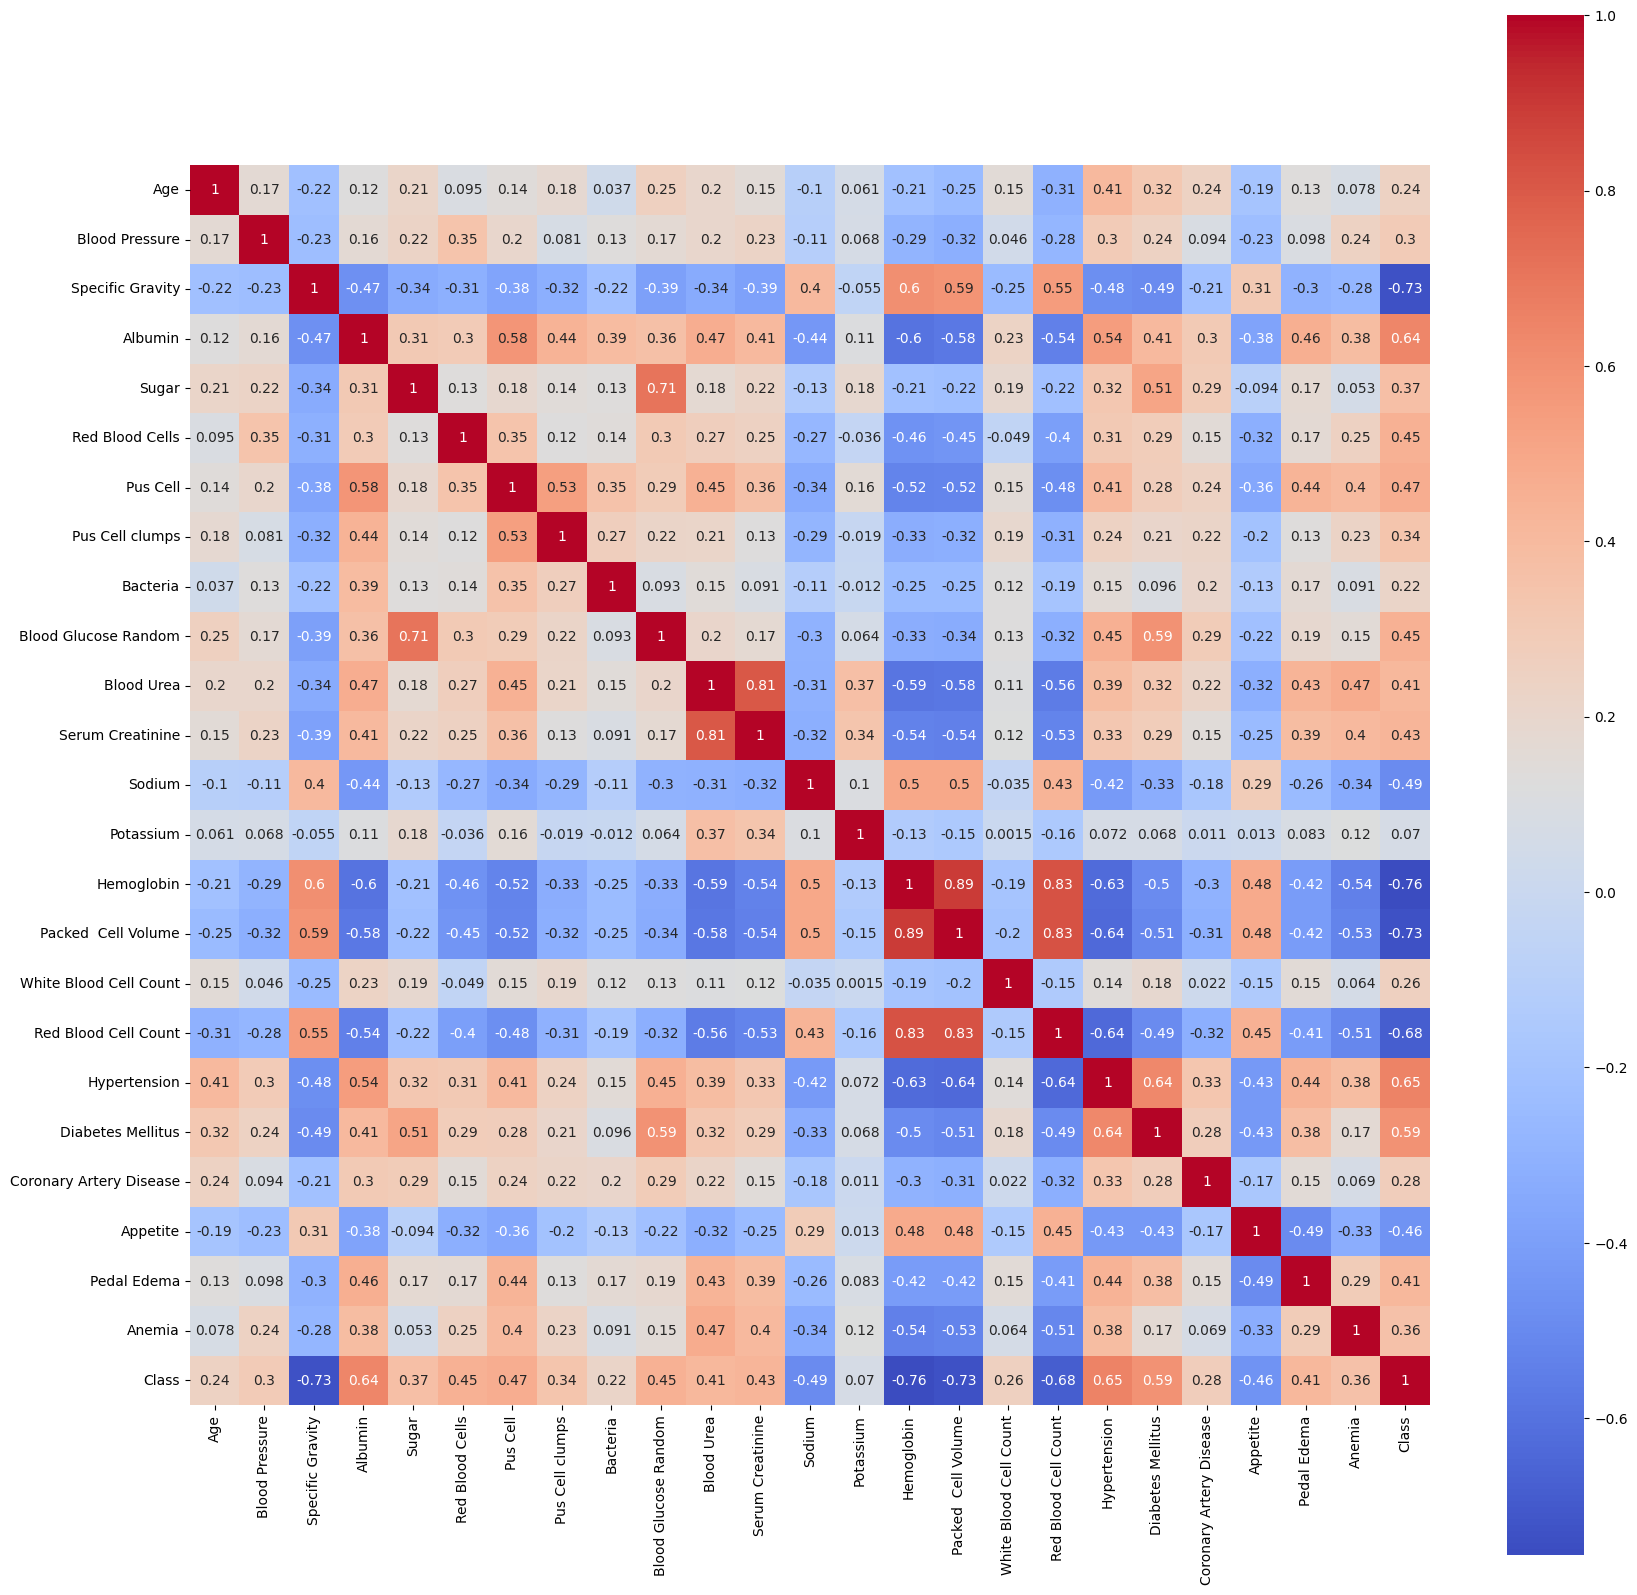

         Current function value: 2.601671
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  330
Model:                          Logit   Df Residuals:                      308
Method:                           MLE   Df Model:                           21
Date:                Fri, 27 Oct 2023   Pseudo R-squ.:                  -2.779
Time:                        04:50:46   Log-Likelihood:                -858.55
converged:                      False   LL-Null:                       -227.18
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -19.3404     29.195     -0.662      0.508     -76.561      37.880
Age                       

c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'\n# check colinearity, source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/\nvif_data = pd.DataFrame() \nvif_data["feature"] = column \n# calculating VIF for each feature \nvif_data["VIF"] = [variance_inflation_factor(kidney_data.values, i) \n                          for i in range(len(kidney_data.columns))] \n                          '

In [173]:
# print(df_imputed)
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
# 轉換成one hot
df_imputed = df_imputed.replace('normal', 0).replace('abnormal', 1).replace('notpresent', 0).replace('present', 1).replace('no', 0).replace('yes', 1).replace('poor', 0).replace('good', 1)
y = kidney_data['Class'].replace('notckd', 0).replace('ckt', 1).astype(bool)
corr_df = df_imputed
corr_df['Class'] = y
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', cbar=True, square=True)
plt.show()
df_imputed.drop('Hemoglobin', axis=1, inplace=True)
df_imputed.drop('Red Blood Cell Count', axis=1, inplace=True)
df_imputed.drop('Packed  Cell Volume', axis=1, inplace=True)
df_imputed.drop('Specific Gravity', axis=1, inplace=True)
# print(df_imputed)
df_imputed.apply(pd.to_numeric)
df_imputed = sm.add_constant(df_imputed)
log_reg = sm.Logit(y.astype(int), df_imputed.astype(float)).fit()
print(log_reg.summary())

(e) 試問配適線性判別分析模型是否合適？若配適不佳，試說明其可能的原因為何？

合適。R-squared: 0.776，以線性迴歸而言表示可以解釋 0.776 的資料，為一個相對好的配適，亦可以較明顯的從 p-value 中挑選重要的變數。究其可能原因，觀察線性迴歸的結果，表現較好的為連續性變數或至少有順序尺度的變數，因此相較於羅吉斯迴歸對於這些變數有更多的解釋性。此外，相對沒有受到共線性的限制，也可能導致結果解釋力較好。

In [176]:
df_imputed = kds.complete_data()
df_imputed = df_imputed.replace('normal', 0).replace('abnormal', 1).replace('notpresent', 0).replace('present', 1).replace('no', 0).replace('yes', 1).replace('poor', 0).replace('good', 1)
y = kidney_data['Class'].replace('notckd', 0).replace('ckt', 1).astype(bool)
regr = linear_model.LinearRegression()
regr.fit(df_imputed.astype(float), y.astype(bool))
df_imputed = sm.add_constant(df_imputed) # adding a constant
model = sm.OLS(y, df_imputed).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Class   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     44.02
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           2.07e-84
Time:                        05:10:33   Log-Likelihood:                 8.8866
No. Observations:                 330   AIC:                             32.23
Df Residuals:                     305   BIC:                             127.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

(f) 試問配適二次判別分析模型是否合適？若配適不佳，試說明其可能的原因為何？

受到共線性的影響，透過捨棄更多的變數，導致配適度不佳，且目前沒有找到可以移除共線性的組合。此外亦有嘗試重新分配成常態分配，但同樣無法得出理想結果。最後做出來的指標輸出於下方，可見結果將 Class 全部判別為 False。究其原因，可能本數據集有較多非常態分布以及離散的欄位（見下圖），在此模型必須假設常態分布的前提下導致配適不佳。

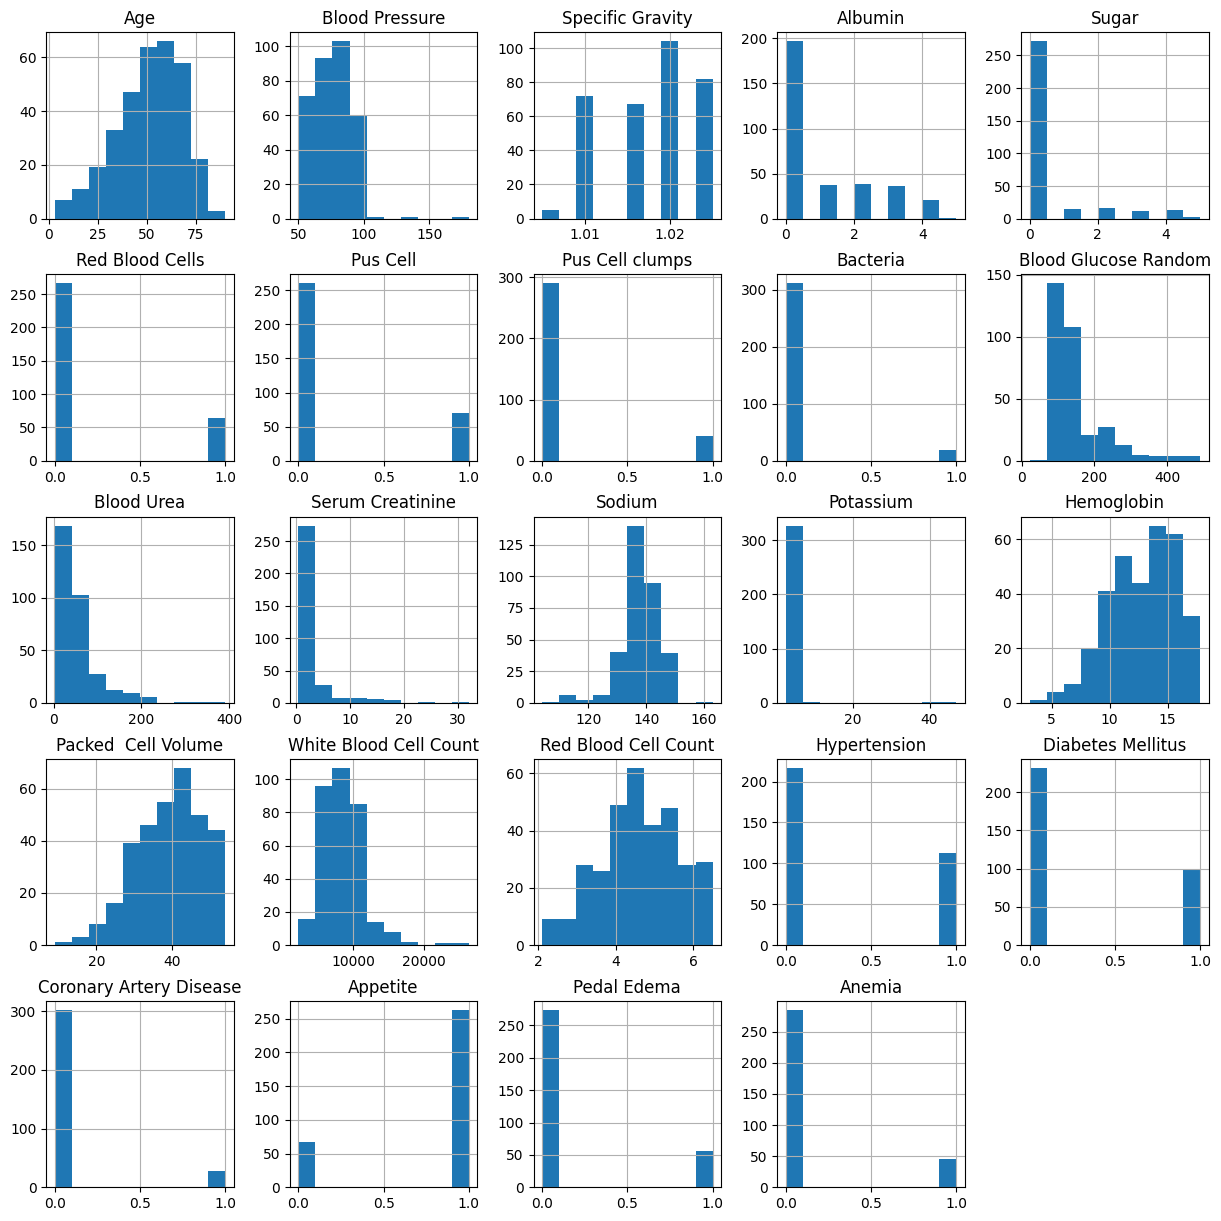

0.45151515151515154
              precision    recall  f1-score   support

       False       0.45      1.00      0.62       149
        True       0.00      0.00      0.00       181

    accuracy                           0.45       330
   macro avg       0.23      0.50      0.31       330
weighted avg       0.20      0.45      0.28       330



c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

"\ndf_imputed.drop('Hemoglobin', axis=1, inplace=True)\ndf_imputed.drop('Red Blood Cell Count', axis=1, inplace=True)\ndf_imputed.drop('Packed  Cell Volume', axis=1, inplace=True)\ndf_imputed.drop('Specific Gravity', axis=1, inplace=True)\ndf_imputed.drop('Blood Urea', axis=1, inplace=True)\ndf_imputed.drop('Hypertension', axis=1, inplace=True)\ndf_imputed.drop('Albumin', axis=1, inplace=True)\ndf_imputed.drop('Diabetes Mellitus', axis=1, inplace=True)\ndf_imputed.drop('Sugar', axis=1, inplace=True)\ndf_imputed.drop('Blood Glucose Random', axis=1, inplace=True)\n"

In [228]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
df_imputed = kds.complete_data()
df_imputed = df_imputed.replace('normal', 0).replace('abnormal', 1).replace('notpresent', 0).replace('present', 1).replace('no', 0).replace('yes', 1).replace('poor', 0).replace('good', 1)
y = kidney_data['Class'].replace('notckd', 0).replace('ckt', 1).astype(bool)
df_imputed.astype(float).hist(layout = (5, 5), figsize=(15, 15))
plt.show()

# g = sns.FacetGrid(dfm, col='columns')
# g = (g.map(sns.distplot, 'value'))
# df_imputed = sm.add_constant(df_imputed)
model = QuadraticDiscriminantAnalysis(store_covariance=True)
model.fit(df_imputed.astype(float), y)
# print(model.covariance_[0])
'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_imputed_normalized = scaler.fit_transform(df_imputed)
model = QuadraticDiscriminantAnalysis()
model.fit(df_imputed_normalized, y)'''
# '''
prediction = model.predict(df_imputed)
print(accuracy_score(y, prediction))
print(classification_report(y, prediction))
# '''

'''
df_imputed.drop('Hemoglobin', axis=1, inplace=True)
df_imputed.drop('Red Blood Cell Count', axis=1, inplace=True)
df_imputed.drop('Packed  Cell Volume', axis=1, inplace=True)
df_imputed.drop('Specific Gravity', axis=1, inplace=True)
df_imputed.drop('Blood Urea', axis=1, inplace=True)
df_imputed.drop('Hypertension', axis=1, inplace=True)
df_imputed.drop('Albumin', axis=1, inplace=True)
df_imputed.drop('Diabetes Mellitus', axis=1, inplace=True)
df_imputed.drop('Sugar', axis=1, inplace=True)
df_imputed.drop('Blood Glucose Random', axis=1, inplace=True)
'''